# DCGAN on Bricks Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb), Lincense: Apache-2.0
- Dataset: [Kaggle](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import metrics as Metrics

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state

import optax
from clu import metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 100
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4

## 1. Prepare dataset

In [3]:
# Convert images to tensors normalize them
def preprocess(img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

# Load lego dataset from directory
def get_dataset():
    train_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='grayscale',
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=None,
        shuffle=True,
        seed=1024,
        interpolation='bilinear',
    ) 

    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds

In [4]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i], cmap='gray')
        ax.axis('off')
    plt.show()

Found 40000 files belonging to 1 classes.
(128, 64, 64, 1)


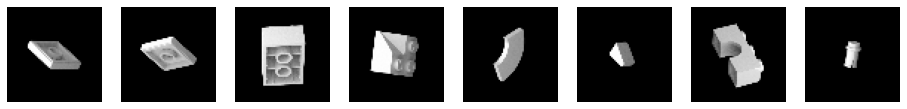

In [5]:
check_ds = get_dataset()
check_sample = next(iter(check_ds))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [6]:
class Discriminator(nn.Module):

    channel_list: tuple = (64, 128, 256, 512)
    
    @nn.compact
    def __call__(self, x, train:bool):

        # Convolutional layers
        for i, features in enumerate(self.channel_list):
            x = self.conv_block(x, features, i, train)

        # Output layers
        x = nn.Conv(features=1, kernel_size=(4, 4), strides=1, 
                    padding='valid', use_bias=False)(x)
        x = x.reshape(-1, 1)
        return x

    # Downsampling convolution block
    def conv_block(self, x, out_features, use_bn, train:bool):
        x = nn.Conv(features=out_features, kernel_size=(4, 4), strides=2,
                    padding='same', use_bias=False)(x)
        
        if use_bn:
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        return x

net_D = Discriminator()
print(net_D.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 1)), train=False, console_kwargs={'width': 120}))


                                                 Discriminator Summary                                                  
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module        ┃ inputs               ┃ outputs              ┃ batch_stats        ┃ params              ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│             │ Discriminator │ - float32[1,64,64,1] │ float32[1,1]         │                    │                     │
│             │               │ - train: False       │                      │                    │                     │
├─────────────┼───────────────┼──────────────────────┼──────────────────────┼────────────────────┼─────────────────────┤
│ Conv_0      │ Conv          │ float32[1,64,64,1]   │ float32[1,32,32,64]  │                    │ kernel:             │
│             │               │

In [7]:
class Generator(nn.Module):
    z_dim: int
    channel_list:tuple = (512, 256, 128, 64)

    @nn.compact
    def __call__(self, x, train:bool):
        x = x.reshape(x.shape[0], 1, 1, x.shape[1])

        # Transpose convolution layers
        for i, features in enumerate(self.channel_list):
            strides = 2 if i else 1
            padding = 'SAME' if i else 'VALID'
            x = self.transconv_block(x, features, strides, padding, train)

        # Output layers
        x = nn.ConvTranspose(features=CHANNELS, kernel_size=(4, 4), strides=(2, 2),
                             padding='SAME', use_bias=False)(x)
        x = nn.tanh(x)
        return x
        

    def transconv_block(self, x, out_features, strides, padding:str, train:bool):
        x = nn.ConvTranspose(features=out_features, kernel_size=(4, 4), strides=(strides, strides),
                             padding=padding, use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return x

netG = Generator(Z_DIM)
print(netG.tabulate(jax.random.PRNGKey(0), jnp.ones((1, Z_DIM)), train=False, console_kwargs={'width': 120}))


                                                   Generator Summary                                                    
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ path            ┃ module        ┃ inputs             ┃ outputs            ┃ batch_stats        ┃ params              ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│                 │ Generator     │ - float32[1,100]   │ float32[1,64,64,1] │                    │                     │
│                 │               │ - train: False     │                    │                    │                     │
├─────────────────┼───────────────┼────────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ ConvTranspose_0 │ ConvTranspose │ float32[1,1,1,100] │ float32[1,4,4,512] │                    │ kernel:             │
│                 │            

## 3. Functions for `TrainState`

In [8]:
from typing import Any

# adding batch_stats and dropout keys to the properities of the class
class TrainState(train_state.TrainState):
    batch_stats: Any # for batch normalization layers
    key: jax.random.KeyArray = None # for dropout layers


# funtion to create a train state for modules
def create_train_state(module, init_array, 
                       params_key, dropout_key, 
                       learning_rate, train=False):
    """
    module: flax module
    init_array: jax.numpy.ones(shape=module_input_shape)
    param_key, dropout_key: jax.random.PRNGkey(0)
    """

    # Initialize the model with initialization array
    variables = module.init(params_key, init_array, train=False)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Create an optimizer
    tx = optax.adam(learning_rate=learning_rate, b1=ADAM_BETA_1, b2=ADAM_BETA_2)

    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            batch_stats=batch_stats,
            key=dropout_key,
            tx=tx
            )

## 4. Train step functions

In [51]:
@jax.jit
def generate_imgs(g_state, latents):
    return g_state.apply_fn(
        {'params': g_state.params, 'batch_stats': g_state.batch_stats},
        latents,
        train=False
    )


@jax.jit
def train_disciminator(d_state, imgs, labels):
    # fold in random keys for dropout layers
    dropout_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    
    def loss_fn(params):
        logits, updates = d_state.apply_fn(
            {'params': params, 'batch_stats': d_state.batch_stats},
            imgs,
            train=True,
            rngs={'dropout': dropout_key},
            mutable=['batch_stats']
        )
        loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
        return loss, updates
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(d_state.params)
    d_state = d_state.apply_gradients(grads=grads)
    # update batch norm stats
    d_state = d_state.replace(batch_stats=updates['batch_stats'])
    
    return d_state


@jax.jit
def train_generator(d_state, g_state, latents, real_labels):

    def loss_fn(params):
        # Generate images
        fake_imgs, updates = g_state.apply_fn(
            {'params': params, 'batch_stats': g_state.batch_stats},
            latents,
            train=True,
            mutable=['batch_stats']
        )
        # Predict generated images with the discriminator
        logits = d_state.apply_fn(
            {'params':d_state.params, 'batch_stats': d_state.batch_stats},
            fake_imgs,
            train=False
        )
        loss = optax.sigmoid_binary_cross_entropy(logits, real_labels).mean()
        return loss, updates
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(g_state.params)
    g_state = g_state.apply_gradients(grads=grads)

    # Update batch norm stats
    g_state = g_state.replace(batch_stats=updates['batch_stats'])
    return g_state


@jax.jit
def compute_metrics(*, d_state, g_state, 
                    real_imgs, fake_imgs, 
                    real_labels, fake_labels):

    real_preds = d_state.apply_fn(
        {'params': d_state.params, 'batch_stats': d_state.batch_stats},
        real_imgs,
        train=False
    )

    fake_preds = d_state.apply_fn(
        {'params': d_state.params, 'batch_stats': d_state.batch_stats},
        fake_imgs,
        train=False
    )

    d_real_loss = optax.sigmoid_binary_cross_entropy(real_preds, real_preds).mean()
    d_fake_loss = optax.sigmoid_binary_cross_entropy(fake_preds, fake_preds).mean()
    d_loss = d_real_loss + d_fake_loss
    g_loss = optax.sigmoid_binary_cross_entropy(fake_preds, real_preds).mean()
    
    return d_loss, g_loss, real_preds, fake_preds                    

## 5. Load dataset and initialze the `TrainState` for both nets

In [52]:
train_ds = get_dataset()

tf.random.set_seed(10)

root_key = jax.random.PRNGKey(0)
d_param_key, g_param_key, dropout_key = jax.random.split(key=root_key, num=3)

d_net = Discriminator()
g_net = Generator(Z_DIM)

d_state = create_train_state(d_net, jnp.ones(shape=(1, 64, 64, 1)), d_param_key, dropout_key, LR)
g_state = create_train_state(g_net, jnp.ones(shape=(1, Z_DIM)), g_param_key, None, LR)

Found 40000 files belonging to 1 classes.


## 6. Training

In [67]:
num_steps_per_epoch = train_ds.cardinality().numpy() // EPOCHS
rng = jax.random.PRNGKey(0)

train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
    'd_real_acc': Metrics.BinaryAccuracy(),
    'd_fake_acc': Metrics.BinaryAccuracy(),
    'g_acc': Metrics.BinaryAccuracy()
}

rng, key = jax.random.split(rng)
real_labels = jnp.ones(shape=(BATCH_SIZE, 1))
real_noisy_labels = real_labels + NOISE_PARAM * jax.random.normal(rng, shape=real_labels.shape)
fake_labels = jnp.zeros(shape=(BATCH_SIZE, 1))
fake_noisy_labels = fake_labels - NOISE_PARAM * jax.random.normal(rng, shape=fake_labels.shape)

In [ ]:
prev_time = time.time()


for step, real_imgs in enumerate(train_ds.as_numpy_iterator()):
    rng, key = jax.random.split(rng)
    
    latents = jax.random.normal(rng, shape=(2, BATCH_SIZE, Z_DIM))
    fake_imgs = generate_imgs(g_state, latents[0])

    # Update discriminator
    d_state = train_disciminator(d_state, real_imgs, real_noisy_labels)
    d_state = train_disciminator(d_state, fake_imgs, fake_noisy_labels)

    # Update generator
    g_state = train_generator(d_state, g_state, latents[1], real_labels)

    # calculate train metrics every epoch
    if (step + 1) % num_steps_per_epoch == 0:
        # Clear metrics
        
        test_batch = train_ds.take(10)
        
        for test_imgs in test_batch.as_numpy_iterator():
            pass

        # Compute metrics

In [57]:
latents = jax.random.normal(jax.random.PRNGKey(0), shape=(BATCH_SIZE, Z_DIM))
fake_imgs = generate_imgs(g_state, latents)

real_labels = jnp.ones(shape=(BATCH_SIZE, 1))

rng, key = jax.random.split(rng)
real_noisy_labels = real_labels + NOISE_PARAM * jax.random.normal(rng, shape=real_labels.shape)
fake_labels = jnp.zeros(shape=(BATCH_SIZE, 1))
fake_noisy_labels = fake_labels - NOISE_PARAM * jax.random.normal(rng, shape=fake_labels.shape)

# d_state = train_disciminator(d_state, real_imgs, real_labels)
# d_state = train_disciminator(d_state, fake_imgs, fake_labels)

# latents = jax.random.normal(jax.random.PRNGKey(0), shape=(BATCH_SIZE, Z_DIM))
# g_state = train_generator(d_state, g_state, latents, real_labels)

# d_loss, g_loss, real_preds, fake_preds = compute_metrics(d_state=d_state, g_state=g_state,fake_imgs=fake_imgs, real_imgs=real_imgs,
#                                                         real_labels=real_labels, fake_labels=fake_labels)

In [77]:
latents = jax.random.normal(rng, shape=(2, 10))
print(latents)

[[-0.69622165 -1.8602761   1.0253826   0.24633065 -1.3455602  -1.5906265
   0.00593245  0.6239486   0.22462466 -1.4013404 ]
 [ 1.8343586  -1.037358   -0.6075037  -0.01211531  1.390547    0.2944951
   0.01563821 -0.5578707  -0.67001504 -0.42912287]]


[-0.69622165 -1.8602761   1.0253826   0.24633065 -1.3455602  -1.5906265
  0.00593245  0.6239486   0.22462466 -1.4013404 ]
